# **Stage 1: Test data loading**  

In [56]:
import zipfile

DATASET_PATH = "content/gtsrb"

TRAIN_DATA = f"{DATASET_PATH}/Train"

#with zipfile.ZipFile("gtsrb.zip",'r') as zip_ref:
    #print("Skipped")
    #zip_ref.extractall("content/gtsrb")

In [57]:
import os

image_paths = []
labels = []

for folder_class_name in os.listdir(TRAIN_DATA):            #folder_class_name = 0 1 2 ..... 42
    class_dir = os.path.join(TRAIN_DATA, folder_class_name) #content/gtsrb/Train\0 1 2 . .... 42

    #Check if the path exixts. If not the skip it and go for next folder_class_name
    if not os.path.isdir(class_dir):
        continue

    for img_file in os.listdir(class_dir):
        full_path = os.path.join(class_dir, img_file)       #content/gtsrb/Train\0 1 2....42\00000_00000_00000.png... 0001234
        image_paths.append(full_path)
        labels.append(int(folder_class_name))

In [58]:
import pandas as pd
from sklearn.model_selection import train_test_split

data_df = pd.DataFrame(
  {
    "image_path": image_paths,
    "label": labels
  }
)


train_data_df, temp_data_df = train_test_split(
    data_df,
    test_size=0.4,
    stratify = data_df['label'],
    random_state = 42
)

# Here the entire test data (temp_data_df) from above is split half into validation and test data
test_data_df, valtest_data_df = train_test_split(
    temp_data_df,
    test_size=0.35,
    stratify=temp_data_df['label'],
    random_state=42
 )

print("Total Test Images: "+str(len(test_data_df.image_path)))
print("Total Test Labels: "+str(len(test_data_df["label"] .unique())))

Total Test Images: 10194
Total Test Labels: 43


# **Stage 2: Helper functions and Traffic classes**  

In [59]:
import cv2
import numpy as np
#!pip install -U protobuf==3.20.3
from tensorflow.keras.utils import to_categorical

IMG_SIZE = 32
NUM_CLASSES = 43




def encode_label(label):
    return to_categorical(label, NUM_CLASSES)




def normalize_image(img):
    # Conver the pixels from (0 - 255) to (0.0 - 1.0)
    return img / 255.0




def load_and_resize_image(img_path):
    # Load the image
    img = cv2.imread(img_path)

    if img is None:
        raise FileNotFoundError(f"Image not found at path: {img_path}")

    # Convert from BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize the size to 32x32
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))

    return img




def load_and_resize_image_ResNet50(img_path):
    # Load the image
    img = cv2.imread(img_path)

    if img is None:
        raise FileNotFoundError(f"Image not found at path: {img_path}")
    
    # Convert from BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize the size to 32x32
    img = cv2.resize(img, (128,128))
    
    return img




def prepare_image_generator(dataframe_df, gen_batch_size = 32, model = None):
    
        for start in range(0, len(dataframe_df), gen_batch_size):
            images = []
            labels = []
            batch_df = dataframe_df[start:start+gen_batch_size]

            '''for image_index_tuple in batch_df.iterrows():
              
              image_index_tuple[0] = index = 31367
              image_index_tuple[1] = 
              31367
              image_path    content/gtsrb/Train\12\00012_00031_00018.png
              label                                                   12
              Name: 6708, dtype: object

              image_index_tuple[1]['image_path'] = content/gtsrb/Train\12\00012_00031_00018.png
              image_index_tuple[1]['lable'] = 12
              '''
            for index, row in batch_df.iterrows():
              
              if row['image_path'] is None or row['image_path'] == '':
                  continue
              if row['label'] == None:
                  continue
              
              df_img_path = row['image_path']
              df_img_label = row['label']
              if model == 'custom_cnn':
                  img = load_and_resize_image(df_img_path)
              else:
                  img = load_and_resize_image_ResNet50(df_img_path)  

              if img is None:
                 continue
              
              img = normalize_image(img)

              images.append(img)
              labels.append(df_img_label)
            
            if len(images) > 0:
                gen_images = np.array(images)
                gen_labels = encode_label(labels)
                yield gen_images, gen_labels




def gaussian_noise(img, sigma = 0.3):
    noise = np.random.normal(0, sigma, img.shape)
    noisy_img = img + noise
    return np.clip(noisy_img, 0.0, 1.0).astype(np.float32) # because noisy_img is of float64 




def simple_blur(img, kernal_size = (3,3)):
    blurred_image = cv2.blur(img, kernal_size)
    return blurred_image.astype(np.float32)




def prepare_image_generator_rq(dataframe_df, gen_batch_size = 32, model = None, rq = None):
    
        for start in range(0, len(dataframe_df), gen_batch_size):
            images = []
            labels = []
            batch_df = dataframe_df[start:start+gen_batch_size]

            '''for image_index_tuple in batch_df.iterrows():
              
              image_index_tuple[0] = index = 31367
              image_index_tuple[1] = 
              31367
              image_path    content/gtsrb/Train\12\00012_00031_00018.png
              label                                                   12
              Name: 6708, dtype: object

              image_index_tuple[1]['image_path'] = content/gtsrb/Train\12\00012_00031_00018.png
              image_index_tuple[1]['lable'] = 12
              '''
            for index, row in batch_df.iterrows():
              
              if row['image_path'] is None or row['image_path'] == '':
                  continue
              if row['label'] == None:
                  continue
              
              df_img_path = row['image_path']
              df_img_label = row['label']
              if model == 'custom_cnn':
                  img = load_and_resize_image(df_img_path)
              else:
                  img = load_and_resize_image_ResNet50(df_img_path)  

              if img is None:
                 continue
              
              img = normalize_image(img)
              if rq == 'noise':
                  img = gaussian_noise(img)
              elif rq == 'blur': 
                  img = simple_blur(img)
              else:
                  continue
              images.append(img)
              labels.append(df_img_label)
            
            if len(images) > 0:
                gen_images = np.array(images)
                gen_labels = encode_label(labels)
                yield gen_images, gen_labels



In [60]:
class_names = [
    "Speed limit 20",
    "Speed limit 30",
    "Speed limit 50",
    "Speed limit 60",
    "Speed limit 70",
    "Speed limit 80",
    "End of speed limit 80",
    "Speed limit 100",
    "Speed limit 120",
    "No passing",
    "No passing for vehicles >3.5t",
    "Right-of-way at intersection",
    "Priority road",
    "Yield",
    "Stop",
    "No vehicles",
    "Vehicles >3.5t prohibited",
    "No entry",
    "General caution",
    "Dangerous curve left",
    "Dangerous curve right",
    "Double curve",
    "Bumpy road",
    "Slippery road",
    "Road narrows on the right",
    "Road work",
    "Traffic signals",
    "Pedestrians",
    "Children crossing",
    "Bicycles crossing",
    "Beware of ice/snow",
    "Wild animals crossing",
    "End of all speed and passing limits",
    "Turn right ahead",
    "Turn left ahead",
    "Ahead only",
    "Go straight or right",
    "Go straight or left",
    "Keep right",
    "Keep left",
    "Roundabout mandatory",
    "End of no passing",
    "End of no passing for vehicles >3.5t"
]


# **Stage 3: Load all the models**  

In [61]:
from tensorflow.keras.models import load_model
import joblib

In [62]:
# Load CNN model
custom_cnn = load_model(r"models\complete_models\custom_cnn\custom_cnn_model.h5")

# Load ResNet50 model
resnet50 = load_model(r"models\complete_models\resnet50\resnet50_model.h5")

# Load the Meta Learner model
meta_learner_model = load_model(r"models\complete_models\meta_learner\meta_learner_model.h5")

# **RQ 1:**
**In the context of traffic sign recognition models, how does a lightweight Custom CNN compare to ResNet50 in terms of classification accuracy, per-class performance, and model efficiency on the GTSRB dataset?**  

In [63]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

test_gen_cnn = prepare_image_generator(
    test_data_df,
    gen_batch_size=32,
    model='custom_cnn'
)

y_true_cnn = []
y_pred_cnn = []

for X_batch, y_batch in test_gen_cnn:
    preds = custom_cnn.predict(X_batch)
    y_true_cnn.extend(np.argmax(y_batch, axis=1))
    y_pred_cnn.extend(np.argmax(preds, axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━

In [64]:
report_df_cnn = pd.DataFrame(classification_report(y_true_cnn, y_pred_cnn, output_dict=True, digits=4))
report_df_cnn.transpose().to_excel("outputs\Tables\RQ1_Tab1.xlsx", index=True)
report_df_cnn.transpose()

,precision,recall,f1-score,support
0,1.000000,1.000000,1.000000,55.000000
1,0.996546,1.000000,0.998270,577.000000
2,0.998288,0.996581,0.997434,585.000000
3,0.997275,0.997275,0.997275,367.000000
4,0.998058,0.998058,0.998058,515.000000
5,0.995859,0.993802,0.994829,484.000000
6,0.981982,1.000000,0.990909,109.000000
7,0.997326,0.997326,0.997326,374.000000
8,1.000000,0.997275,0.998636,367.000000
9,1.000000,1.000000,1.000000,382.000000


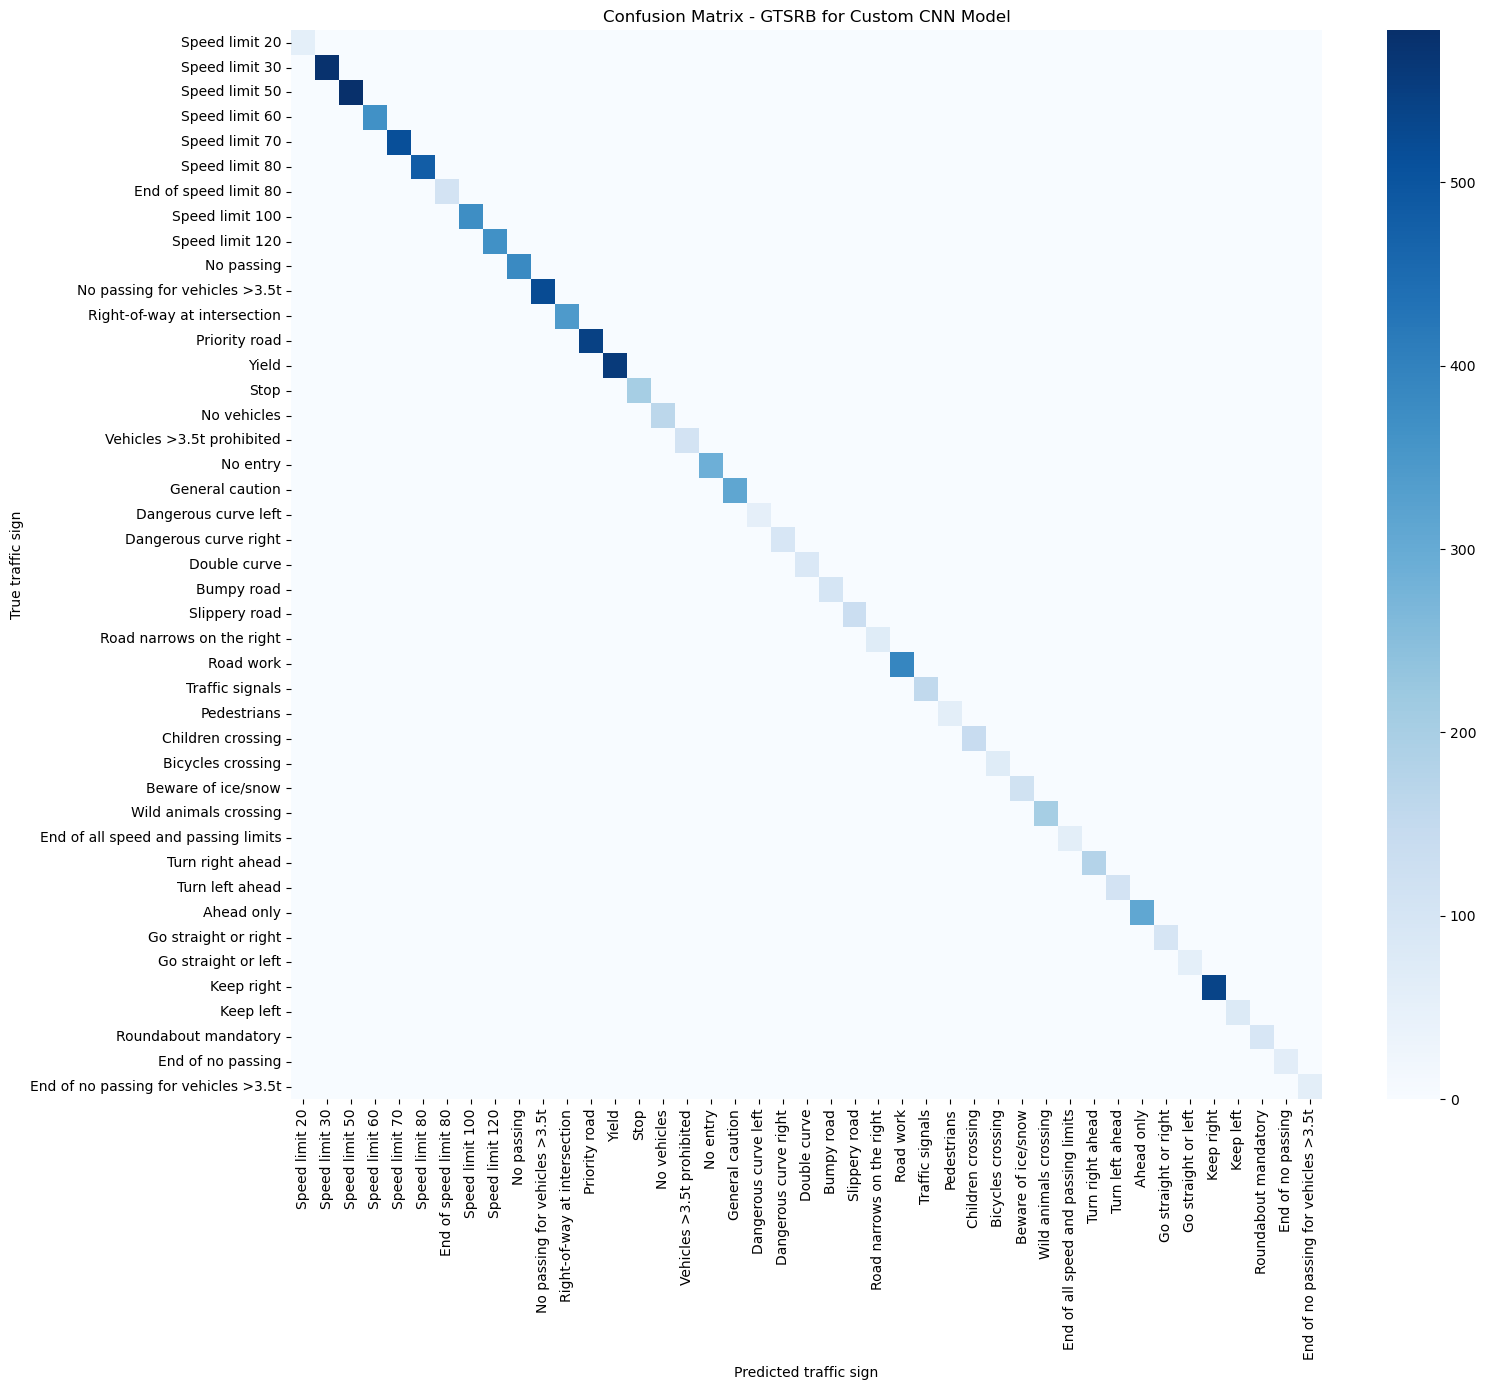

In [65]:
#!pip install matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

custom_cnn_cm = confusion_matrix(y_true_cnn, y_pred_cnn)

plt.figure(figsize=(16,14))
sns.heatmap(
    custom_cnn_cm,
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)

plt.xlabel("Predicted traffic sign")
plt.ylabel("True traffic sign")
plt.title("Confusion Matrix - GTSRB for Custom CNN Model")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("outputs\Figures\RQ1_Fig1.pdf", dpi=300)
plt.show()


In [66]:
test_gen_resnet = prepare_image_generator(
    test_data_df,
    gen_batch_size=32,
    model='resnet50'
)

y_true_resnet50 = []
y_pred_resnet50 = []

for X_batch, y_batch in test_gen_resnet:
    preds = resnet50.predict(X_batch)
    y_true_resnet50.extend(np.argmax(y_batch, axis=1))
    y_pred_resnet50.extend(np.argmax(preds, axis=1))


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [67]:
report_df_resnet50 = pd.DataFrame(classification_report(y_true_resnet50, y_pred_resnet50, output_dict=True, digits=4))
report_df_resnet50.transpose().to_excel("outputs\Tables\RQ1_Tab2.xlsx", index=True)
report_df_resnet50.transpose()

,precision,recall,f1-score,support
0,0.979167,0.854545,0.912621,55.000000
1,0.629339,0.974003,0.764626,577.000000
2,0.824232,0.825641,0.824936,585.000000
3,0.301394,0.942779,0.456766,367.000000
4,0.942197,0.633010,0.757259,515.000000
5,0.609700,0.545455,0.575791,484.000000
6,0.702899,0.889908,0.785425,109.000000
7,0.870091,0.770053,0.817021,374.000000
8,1.000000,0.305177,0.467641,367.000000
9,0.988604,0.908377,0.946794,382.000000


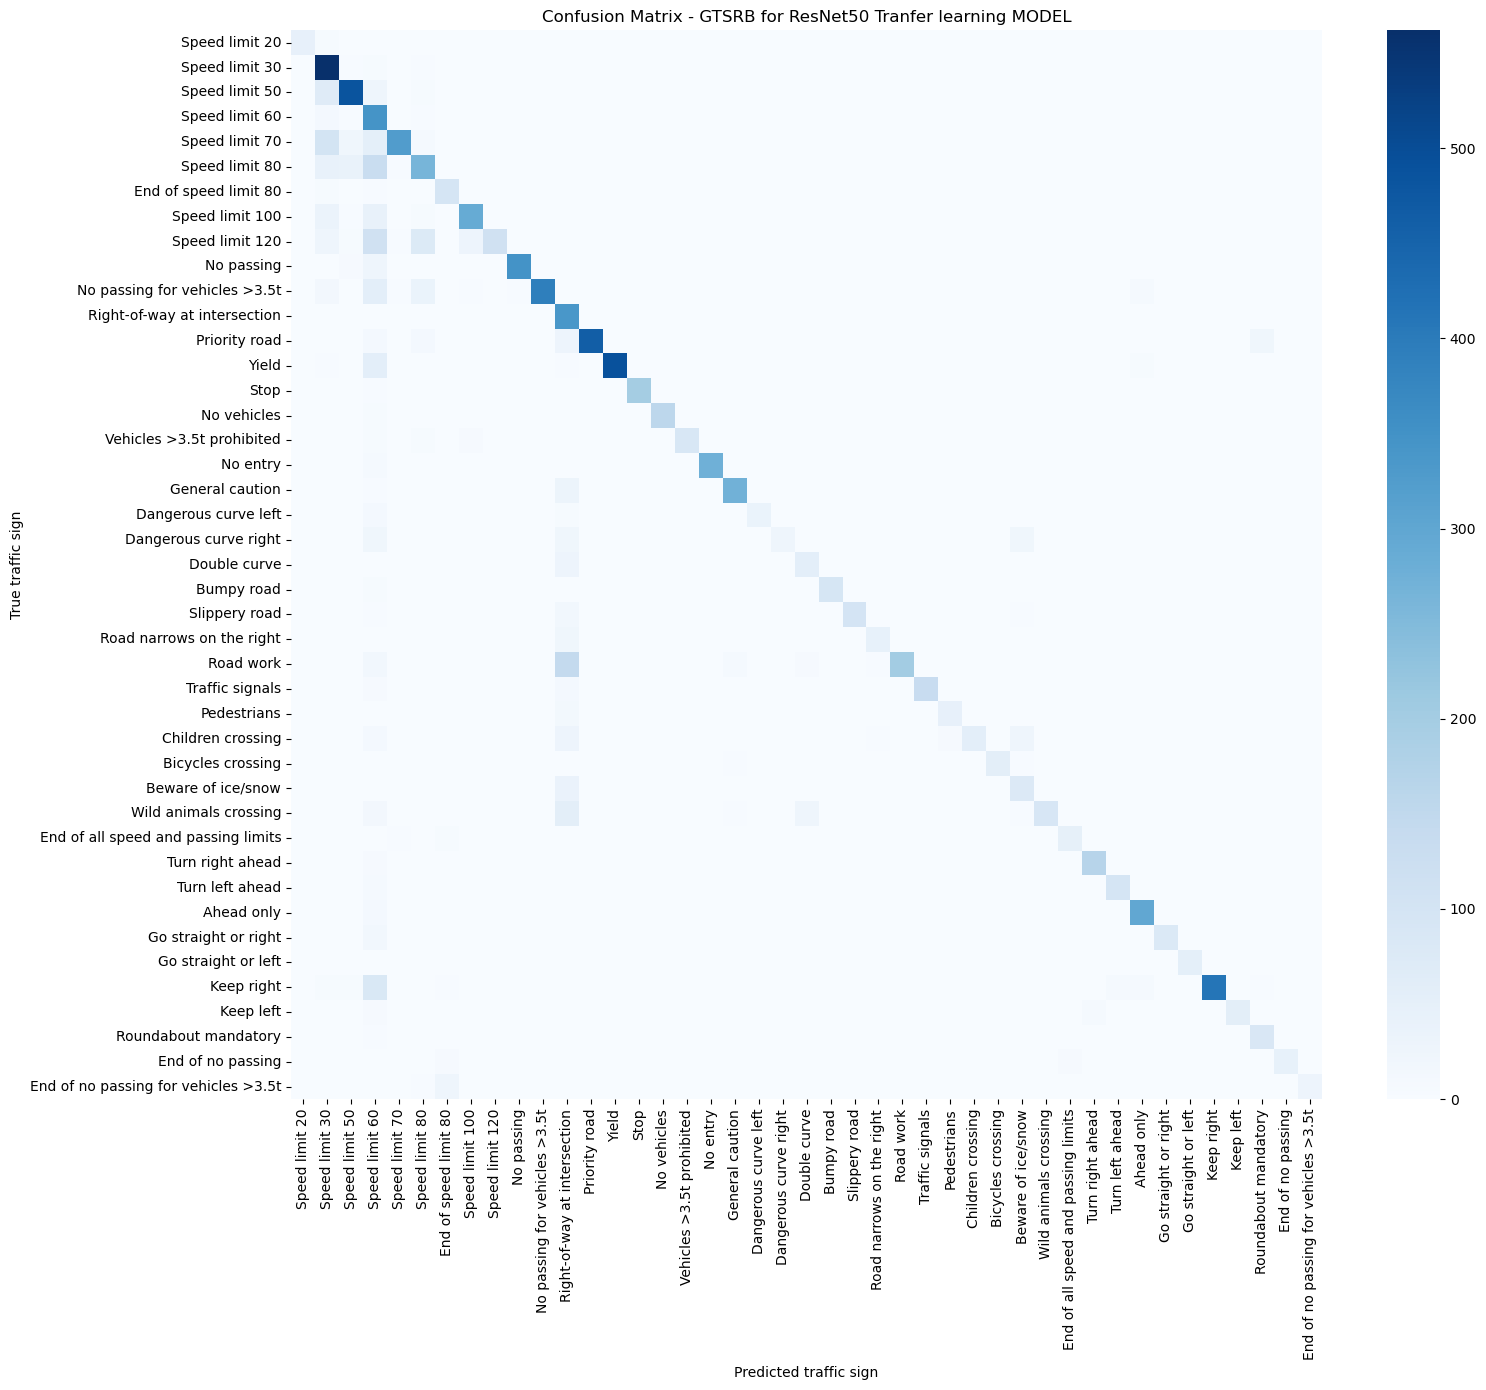

In [68]:
#!pip install matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

resnet50_cm = confusion_matrix(y_true_resnet50, y_pred_resnet50)

plt.figure(figsize=(16,14))
sns.heatmap(
    resnet50_cm,
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)

plt.xlabel("Predicted traffic sign")
plt.ylabel("True traffic sign")
plt.title("Confusion Matrix - GTSRB for ResNet50 Tranfer learning MODEL")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("outputs\Figures\RQ1_Fig2.pdf", dpi=300)
plt.show()


In [69]:
import os
import pandas as pd

print("Custom CNN size (MB):",
      os.path.getsize("models/complete_models/custom_cnn/custom_cnn_model.h5") / (1024*1024))

print("ResNet50 size (MB):",
      os.path.getsize("models/complete_models/resnet50/resnet50_model.h5") / (1024*1024))
size = []
size.append(os.path.getsize("models/complete_models/custom_cnn/custom_cnn_model.h5") / (1024*1024))
size.append(os.path.getsize("models/complete_models/resnet50/resnet50_model.h5") / (1024*1024))

size_pd = pd.DataFrame(
    {
        "Model": ['Custom CNN','ResNet50'],
        "Size": size
    }
)
size_pd.to_excel("outputs\Tables\RQ1_Tab3.xlsx", index=True)
size_pd


Custom CNN size (MB): 4.177936553955078
ResNet50 size (MB): 126.15707015991211


,Model,Size
0,Custom CNN,4.177937
1,ResNet50,126.157070


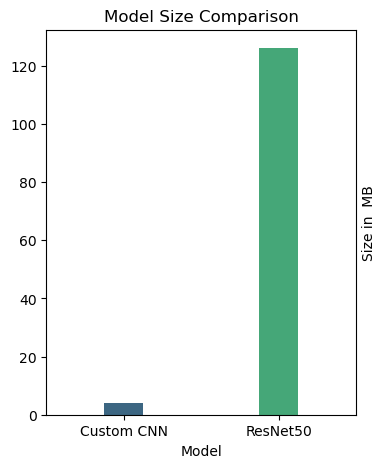

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(4,5))

bar_plot = sns.barplot(x = "Model", y= "Size", data=size_pd, width=0.25, palette='viridis', hue="Model")

plt.xlabel("Model")
plt.ylabel("Size in  MB")
plt.title('Model Size Comparison')
bar_plot.yaxis.set_label_position("right")
bar_plot.yaxis.tick_right
plt.savefig("outputs\Figures\RQ1_Fig3.pdf", dpi=300)
plt.show()


# **RQ 2:**
**How can integrating a Meta Learner with a lightweight Custom CNN improve the reliability and efficiency of traffic sign recognition for real-time intelligent transportation systems?**

In [71]:
# CNN predictions
probs_test_cnn = []
test_labels = []
gen_batch_size = 224

test_images_generator = prepare_image_generator(test_data_df, gen_batch_size, model='custom_cnn')
for image_batch, labels in test_images_generator:
    probs_test_cnn.append(custom_cnn.predict(image_batch))
    test_labels.append(labels)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
7/7 ━━━━━━━━

In [72]:
# ResNet50 predictions
probs_test_resnet50 = []
gen_batch_size = 224

train_images_generator = prepare_image_generator(test_data_df, gen_batch_size, model='resnet50')
for image_batch, labels in train_images_generator:
    probs_test_resnet50.append(resnet50.predict(image_batch))


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 317ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 341ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 301ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 312ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 319ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 298ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 312ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 316ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 297ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 302ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 314ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 294ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 309ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 333ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 312ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 323ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 310ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 340ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 334ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 334ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 318ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 321ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 336ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 313ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 306ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 

In [73]:
probs_test_resnet50 = np.vstack(probs_test_resnet50)
probs_test_cnn = np.vstack(probs_test_cnn)
test_labels = np.vstack(test_labels)


probs_test_stack  = np.hstack([probs_test_cnn,probs_test_resnet50])
label_test_stack = test_labels
label_test_stack = np.argmax(test_labels, axis=1)

In [74]:
y_true_meta = []
y_pred_meta = []

preds = meta_learner_model.predict(probs_test_stack)
y_pred_meta = np.argmax(preds, axis=1)
y_true_meta = label_test_stack 

319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step


In [75]:
report_df_meta = pd.DataFrame(classification_report(y_true_meta, y_pred_meta, output_dict=True, digits=4))

# report_df_comparisons will be used further in RQ4
report_df_comparisons = report_df_meta

report_df_meta.transpose().to_excel("outputs\Tables\RQ2_Tab1.xlsx", index=True)
report_df_meta.transpose()

,precision,recall,f1-score,support
0,1.000000,1.000000,1.000000,55.000000
1,0.996546,1.000000,0.998270,577.000000
2,0.998291,0.998291,0.998291,585.000000
3,0.997275,0.997275,0.997275,367.000000
4,0.998058,0.998058,0.998058,515.000000
5,0.995868,0.995868,0.995868,484.000000
6,0.990909,1.000000,0.995434,109.000000
7,0.997326,0.997326,0.997326,374.000000
8,1.000000,0.997275,0.998636,367.000000
9,1.000000,1.000000,1.000000,382.000000


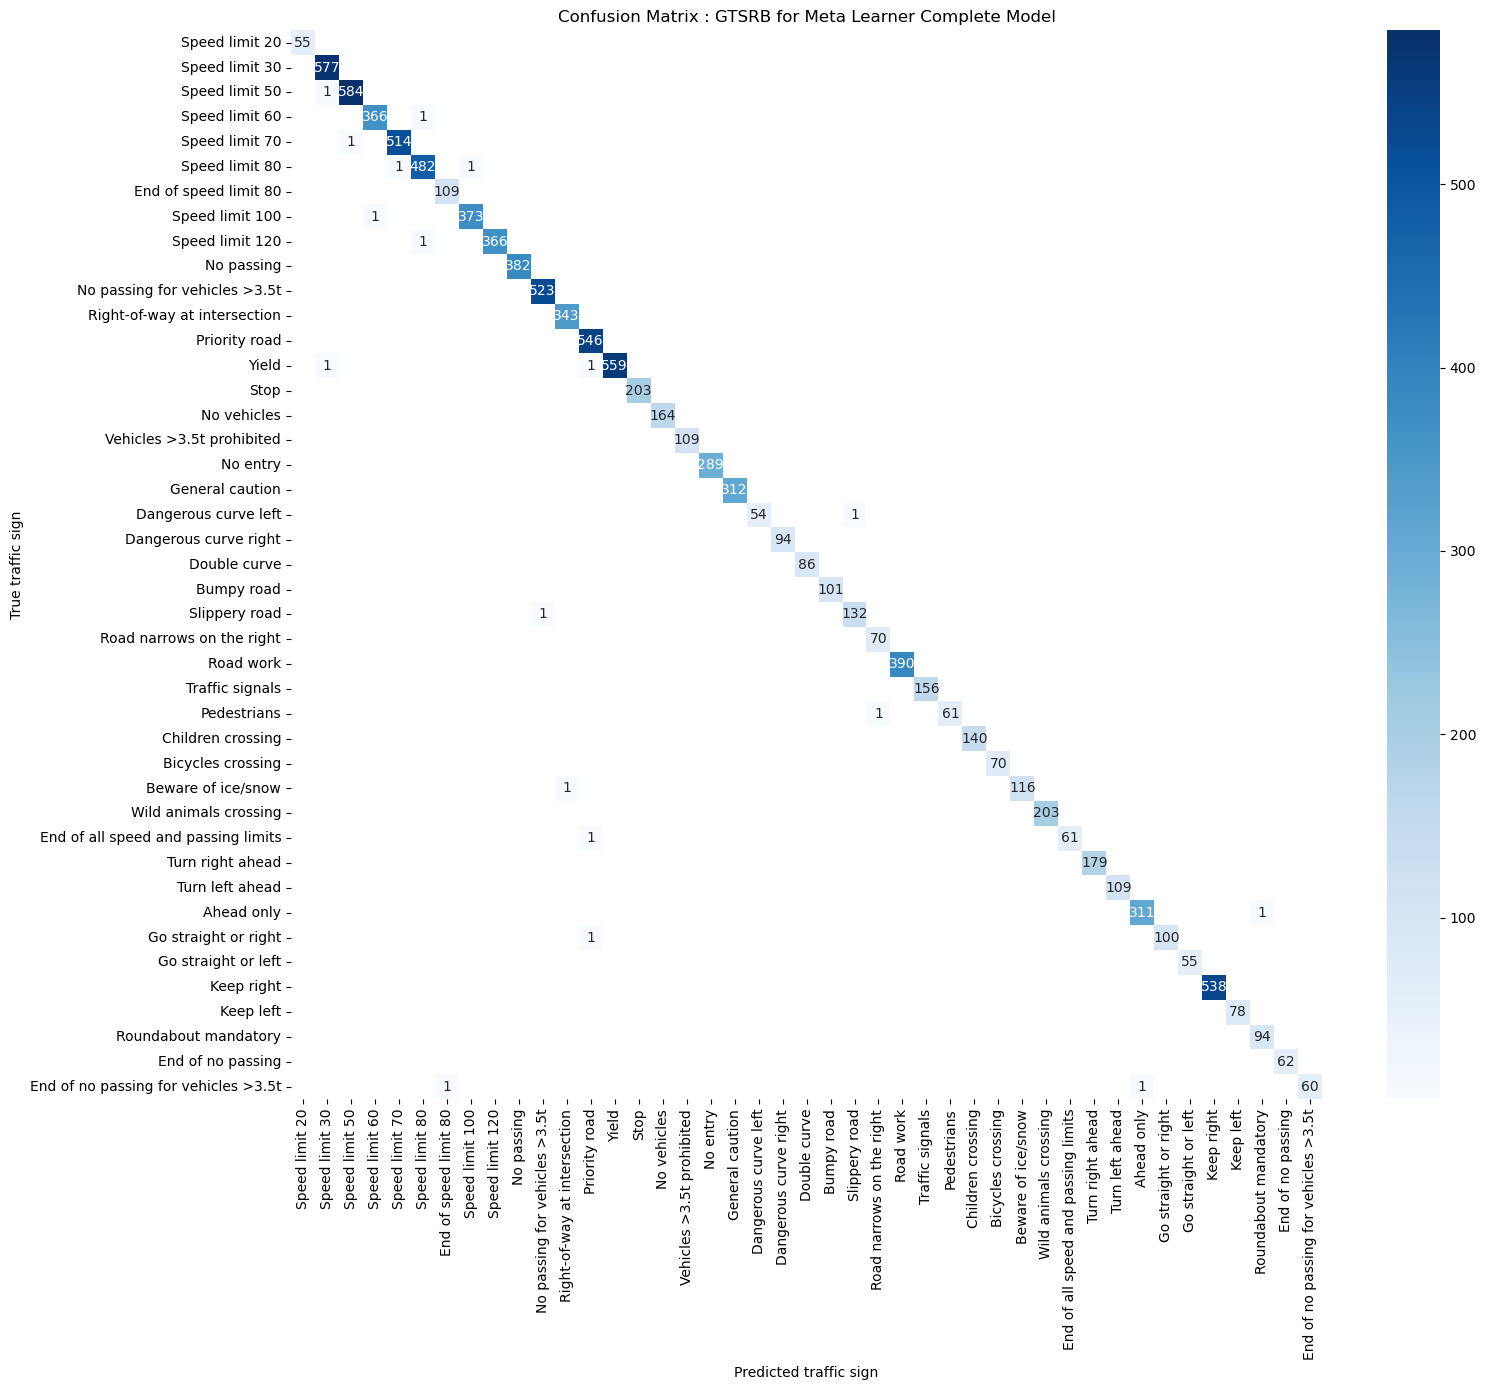

In [76]:
#!pip install matplotlib
import matplotlib.pyplot as plt
import seaborn as sns


meta_cm = confusion_matrix(y_true_meta, y_pred_meta)
mask_zero = meta_cm == 0

plt.figure(figsize=(16,14))
sns.heatmap(
    meta_cm,
    annot=meta_cm,
    fmt='d',
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
    mask=mask_zero
)

plt.xlabel("Predicted traffic sign")
plt.ylabel("True traffic sign")
plt.title("Confusion Matrix : GTSRB for Meta Learner Complete Model")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("outputs\Figures\RQ2_Fig1.pdf", dpi=300) 
plt.show()


In [77]:
report_df_cnn = pd.DataFrame(classification_report(y_true_cnn, y_pred_cnn, output_dict=True, digits=4))
report_df_cnn.transpose().to_excel("outputs\Tables\RQ2_Tab2.xlsx", index=True)
report_df_cnn.transpose()

,precision,recall,f1-score,support
0,1.000000,1.000000,1.000000,55.000000
1,0.996546,1.000000,0.998270,577.000000
2,0.998288,0.996581,0.997434,585.000000
3,0.997275,0.997275,0.997275,367.000000
4,0.998058,0.998058,0.998058,515.000000
5,0.995859,0.993802,0.994829,484.000000
6,0.981982,1.000000,0.990909,109.000000
7,0.997326,0.997326,0.997326,374.000000
8,1.000000,0.997275,0.998636,367.000000
9,1.000000,1.000000,1.000000,382.000000


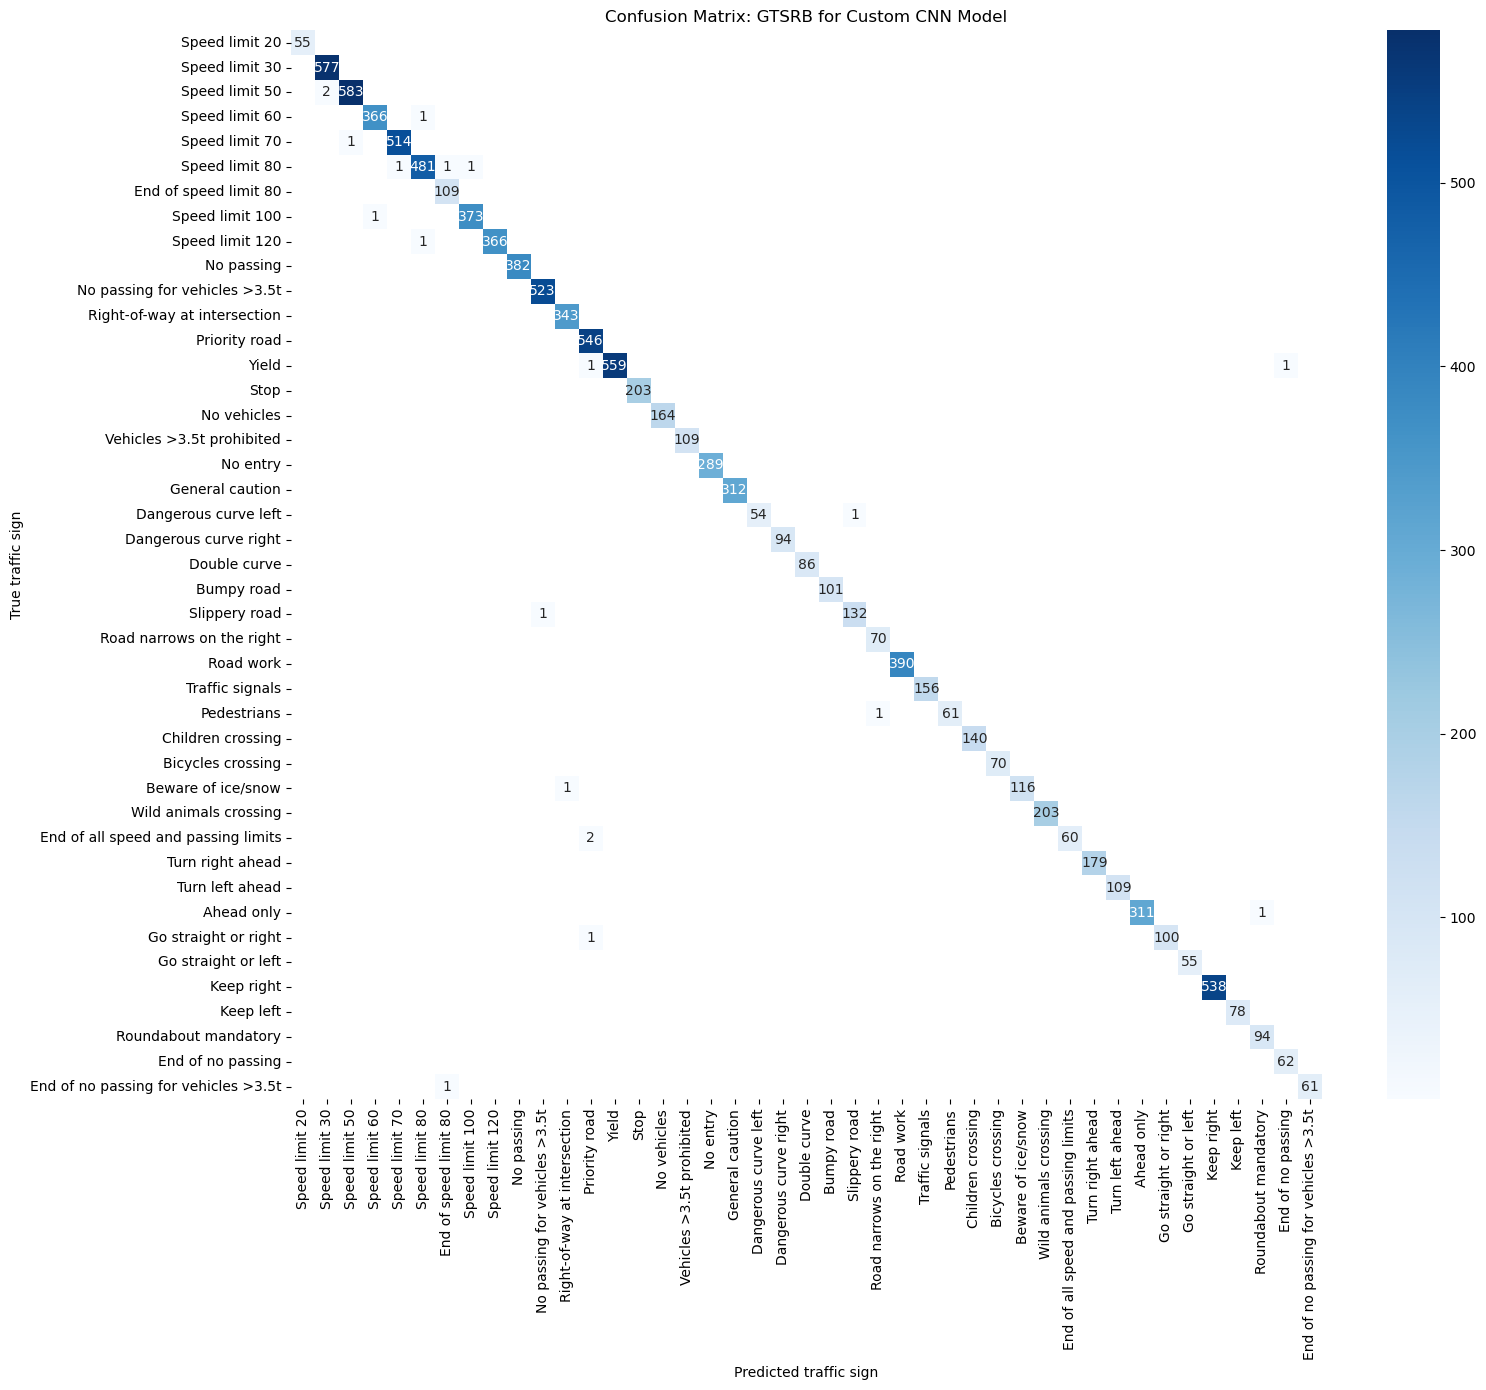

In [78]:
#!pip install matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

custom_cnn_cm = confusion_matrix(y_true_cnn, y_pred_cnn)
mask_zero = custom_cnn_cm == 0

plt.figure(figsize=(16,14))
sns.heatmap(
    custom_cnn_cm,    
    annot=custom_cnn_cm,
    fmt = 'd',
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
    mask=mask_zero
)

plt.xlabel("Predicted traffic sign")
plt.ylabel("True traffic sign")
plt.title("Confusion Matrix: GTSRB for Custom CNN Model")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("outputs\Figures\RQ2_Fig2.pdf", dpi=300)
plt.show()


In [79]:
report_df_meta = pd.DataFrame(classification_report(y_true_meta, y_pred_meta, output_dict=True, digits=4)).transpose()
report_df_cnn  = pd.DataFrame(classification_report(y_true_cnn, y_pred_cnn, output_dict=True, digits=4)).transpose()

metrics = ["precision", "recall", "f1-score","support"] 
diff_report = report_df_meta [metrics]- report_df_cnn[metrics]
diff_report.to_excel("outputs\Tables\RQ2_Tab3.xlsx", index=True)
diff_report

,precision,recall,f1-score,support
0,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000
2,0.000003,0.001709,0.000857,0.000000
3,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000
5,0.000009,0.002066,0.001038,0.000000
6,0.008927,0.000000,0.004525,0.000000
7,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.000000


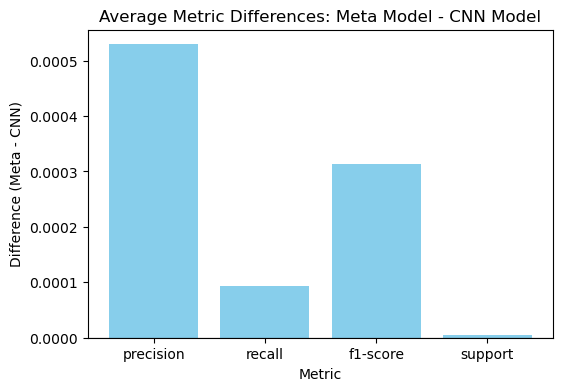

In [80]:
import matplotlib.pyplot as plt

# Take the mean of each metric across all classes
metric_means = diff_report.mean()  # precision, recall, f1-score

# Simple bar graph
plt.figure(figsize=(6,4))
plt.bar(metric_means.index, metric_means.values, color='skyblue')
plt.title("Average Metric Differences: Meta Model - CNN Model")
plt.ylabel("Difference (Meta - CNN)")
plt.xlabel("Metric")
plt.axhline(0, color='black', linewidth=0.8)
plt.savefig("outputs\Figures\RQ2_Fig3.pdf", dpi=300)
plt.show()





# **RQ3**:  
**To what extent can a convolutional neural network–based traffic sign recognition model accurately distinguish between visually similar speed-limit signs (20, 30, 50, 60, 70, and 80 km/h), and what patterns of misclassification and inter-class confusion emerge?**

In [81]:
import os

image_paths_rq3 = []
labels_rq3 = []

for folder_class_name_rq3 in os.listdir(TRAIN_DATA):
    if folder_class_name_rq3 in ['0','1','2','3','4','5']:            #folder_class_name = 0 1 2 ..... 5
        class_dir_rq3 = os.path.join(TRAIN_DATA, folder_class_name_rq3) #content/gtsrb/Train\0 1 2 . .... 5
        #Check if the path exixts. If not the skip it and go for next folder_class_name
        if not os.path.isdir(class_dir_rq3):
            continue
    
        for img_file_rq3 in os.listdir(class_dir_rq3):
            full_path_rq3 = os.path.join(class_dir_rq3, img_file_rq3)       #content/gtsrb/Train\0 1 2....42\00000_00000_00000.png... 0001234
            image_paths_rq3.append(full_path_rq3)
            labels_rq3.append(int(folder_class_name_rq3))

In [82]:
test_data_df_rq3 = pd.DataFrame(
  {
    "image_path": image_paths_rq3,
    "label": labels_rq3
  }
)

In [83]:
# CNN predictions
probs_test_cnn = []
test_labels = []
gen_batch_size = 224

test_images_generator = prepare_image_generator(test_data_df_rq3, gen_batch_size, model='custom_cnn')
for image_batch, labels in test_images_generator:
    probs_test_cnn.append(custom_cnn.predict(image_batch))
    test_labels.append(labels)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━

In [84]:
# ResNet50 predictions
probs_test_resnet50 = []
gen_batch_size = 224

train_images_generator = prepare_image_generator(test_data_df_rq3, gen_batch_size, model='resnet50')
for image_batch, labels in train_images_generator:
    probs_test_resnet50.append(resnet50.predict(image_batch))


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 305ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 295ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 354ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 329ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 344ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 338ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 303ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 310ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 304ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 336ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 347ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 318ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 314ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 320ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 305ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 317ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 321ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 330ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 309ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 300ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 304ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 301ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 303ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 297ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 299ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 

In [85]:
probs_test_resnet50 = np.vstack(probs_test_resnet50)
probs_test_cnn = np.vstack(probs_test_cnn)
test_labels = np.vstack(test_labels)


probs_test_stack  = np.hstack([probs_test_cnn,probs_test_resnet50])
label_test_stack = test_labels
label_test_stack = np.argmax(test_labels, axis=1)

In [86]:
y_true_meta = []
y_pred_meta = []

preds = meta_learner_model.predict(probs_test_stack)
y_pred_meta = np.argmax(preds, axis=1)
y_true_meta = label_test_stack 

311/311 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [87]:
report_df_meta = pd.DataFrame(classification_report(
    y_true_meta, 
    y_pred_meta,
    labels=[0,1,2,3,4,5], 
    output_dict=True, 
    digits=4))
report_df_meta.to_excel("outputs\Tables\RQ3_Tab1.xlsx", index=True)
report_df_meta.transpose()


,precision,recall,f1-score,support
0,0.995261,1.000000,0.997625,210.0
1,0.997300,0.998198,0.997749,2220.0
2,0.997333,0.997333,0.997333,2250.0
3,0.999289,0.997163,0.998225,1410.0
4,0.999494,0.997475,0.998483,1980.0
5,0.997310,0.996774,0.997042,1860.0
micro avg,0.997985,0.997482,0.997734,9930.0
macro avg,0.997665,0.997824,0.997743,9930.0
weighted avg,0.997986,0.997482,0.997734,9930.0


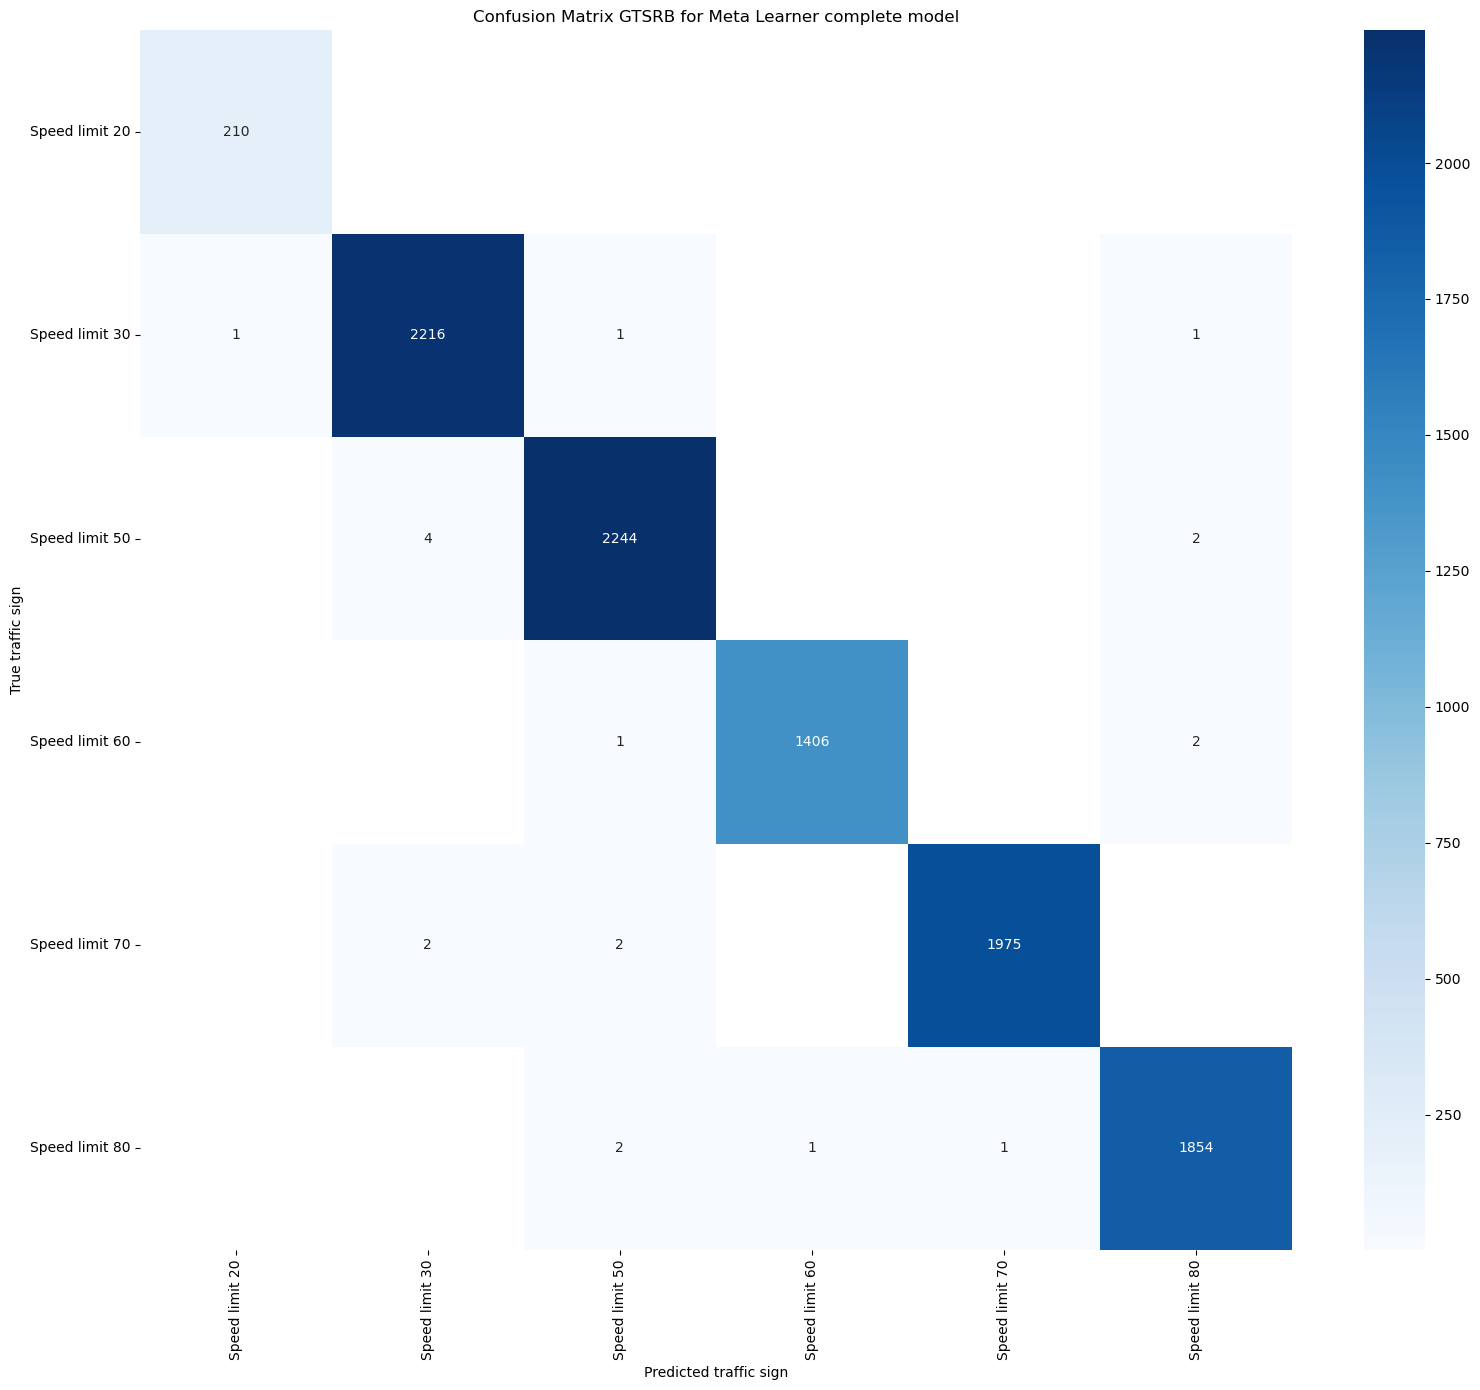

In [88]:
#!pip install matplotlib
import matplotlib.pyplot as plt
import seaborn as sns


meta_cm = confusion_matrix(y_true_meta, 
                           y_pred_meta,
                           labels=[0,1,2,3,4,5]
                           )
mask_zero = meta_cm == 0

plt.figure(figsize=(16,14))
sns.heatmap(
    meta_cm,
    annot=meta_cm,
    fmt='d',
    cmap="Blues",
    xticklabels=class_names[0:6],
    yticklabels=class_names[0:6],
    mask=mask_zero
)

plt.xlabel("Predicted traffic sign")
plt.ylabel("True traffic sign")
plt.title("Confusion Matrix GTSRB for Meta Learner complete model")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("outputs\Figures\RQ3_Fig1.pdf", dpi=300) 
plt.show()


# **RQ 4**:  
**How do visual degradation like image blur affect the prediction accuracy and misclassification patterns of traffic sign recognition models, specifically comparing a custom CNN and a meta-learner model?**

In [89]:
# CNN predictions
probs_test_cnn_rq4 = []
test_labels_rq4 = []
gen_batch_size = 224

test_images_generator = prepare_image_generator_rq(test_data_df, gen_batch_size, model='custom_cnn', rq = 'blur')
for image_batch, labels in test_images_generator:
    probs_test_cnn_rq4.append(custom_cnn.predict(image_batch))
    test_labels_rq4.append(labels)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━

In [90]:
# ResNet50 predictions
probs_test_resnet50_rq4 = []
gen_batch_size = 224

train_images_generator = prepare_image_generator_rq(test_data_df, gen_batch_size, model='resnet50', rq = 'blur')
for image_batch, labels in train_images_generator:
    probs_test_resnet50_rq4.append(resnet50.predict(image_batch))


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 317ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 335ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 319ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 337ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 332ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 304ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 300ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 321ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 314ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 311ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 311ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 322ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 313ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 304ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 304ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 322ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 286ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 341ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 304ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 338ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 309ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 290ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 270ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 286ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 290ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 

In [91]:
probs_test_resnet50_rq4 = np.vstack(probs_test_resnet50_rq4)
probs_test_cnn_rq4 = np.vstack(probs_test_cnn_rq4)
test_labels_rq4 = np.vstack(test_labels_rq4)


probs_test_stack_rq4  = np.hstack([probs_test_cnn_rq4,probs_test_resnet50_rq4])
label_test_stack_rq4 = test_labels_rq4
label_test_stack_rq4 = np.argmax(test_labels_rq4, axis=1)

In [92]:
y_true_meta_rq4 = []
y_pred_meta_rq4 = []

preds_rq4 = meta_learner_model.predict(probs_test_stack_rq4)
y_pred_meta_rq4 = np.argmax(preds_rq4, axis=1)
y_true_meta_rq4 = label_test_stack_rq4

319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


In [93]:
report_df_rq4 = pd.DataFrame(classification_report(y_true_meta_rq4, y_pred_meta_rq4, output_dict=True, digits=4))
report_df_rq4.to_excel("outputs\Tables\RQ4_Tab1.xlsx", index=True)
report_df_rq4.transpose()

,precision,recall,f1-score,support
0,1.000000,0.945455,0.971963,55.000000
1,0.957983,0.987868,0.972696,577.000000
2,0.987762,0.965812,0.976664,585.000000
3,0.981183,0.994550,0.987821,367.000000
4,0.988417,0.994175,0.991288,515.000000
5,0.987474,0.977273,0.982347,484.000000
6,0.973214,1.000000,0.986425,109.000000
7,0.978723,0.983957,0.981333,374.000000
8,1.000000,0.989101,0.994521,367.000000
9,0.994792,1.000000,0.997389,382.000000


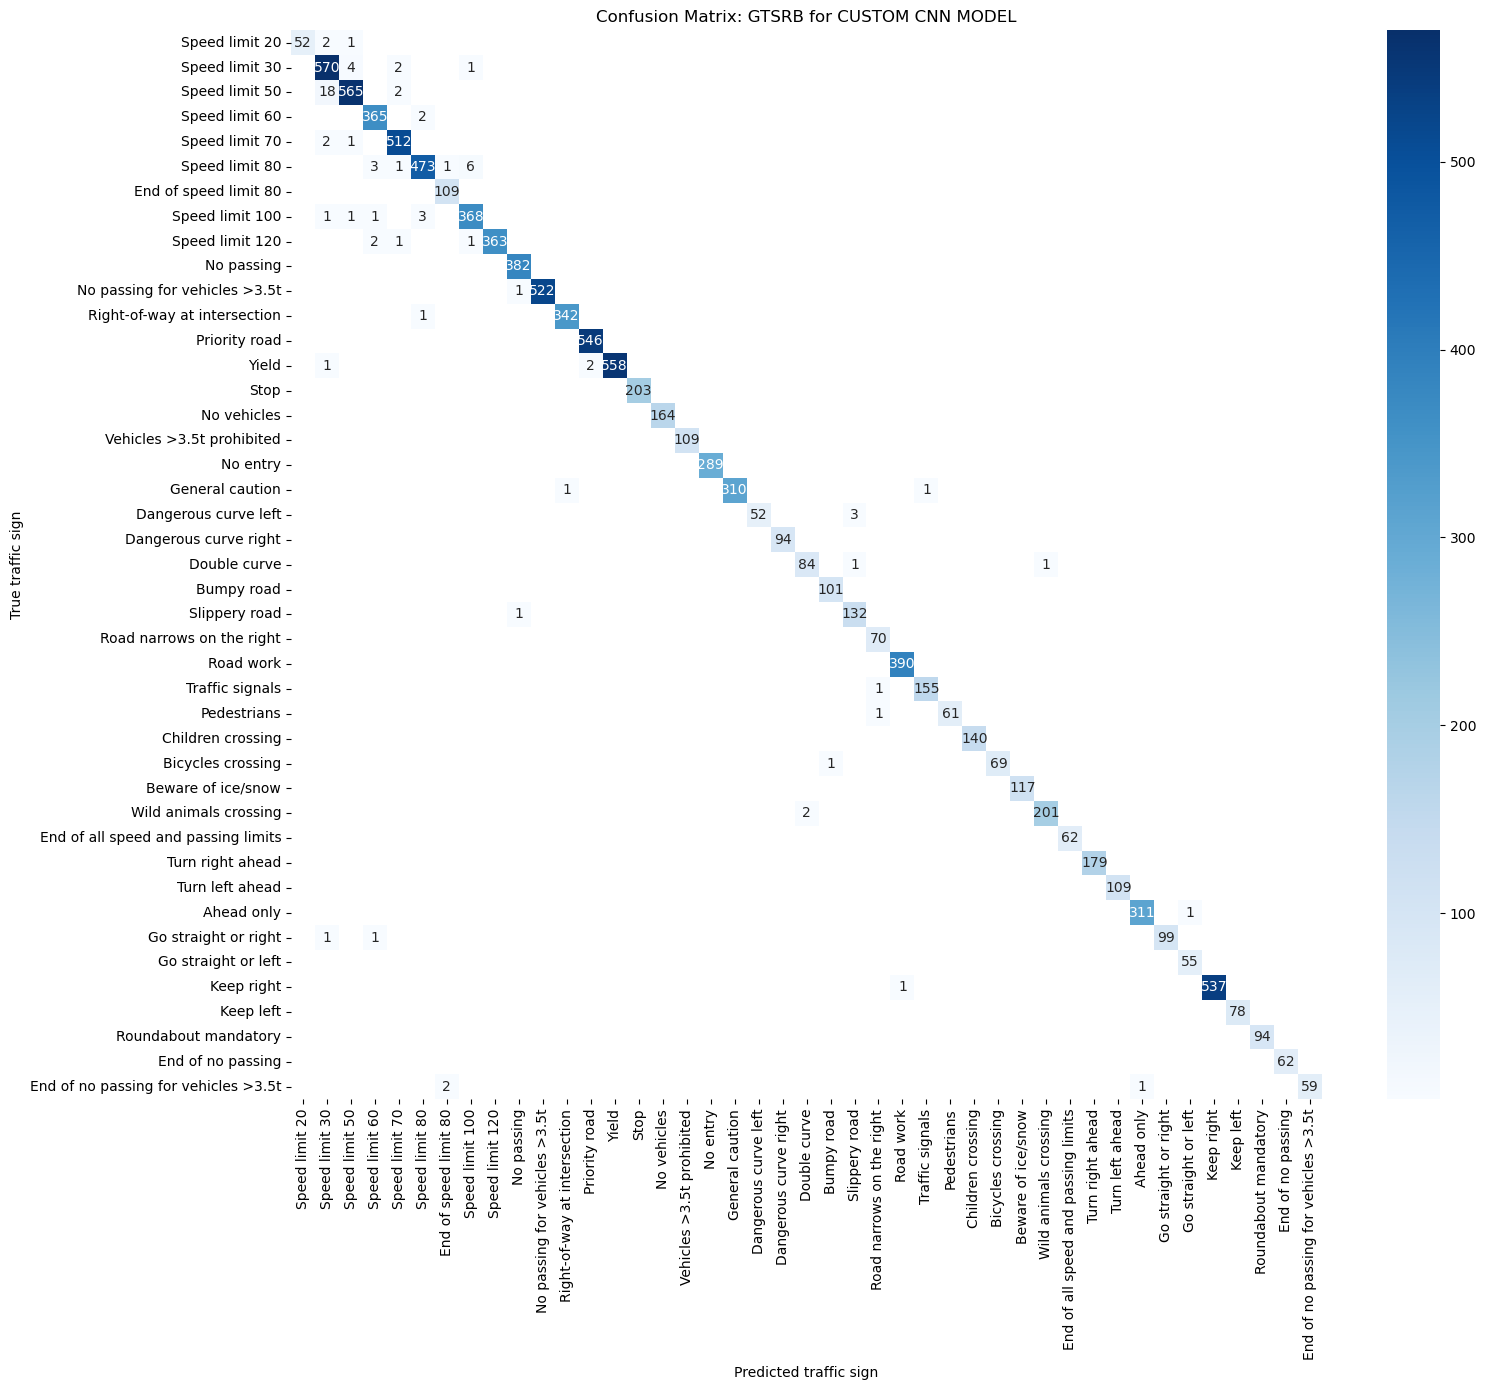

In [94]:
#!pip install matplotlib
import matplotlib.pyplot as plt
import seaborn as sns


cm_rq4 = confusion_matrix(y_true_meta_rq4, y_pred_meta_rq4)
mask_zero = cm_rq4 == 0

plt.figure(figsize=(16,14))
sns.heatmap(
    cm_rq4,    
    annot=cm_rq4,
    fmt = 'd',
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
    mask=mask_zero
)

plt.xlabel("Predicted traffic sign")
plt.ylabel("True traffic sign")
plt.title("Confusion Matrix: GTSRB for CUSTOM CNN MODEL")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("outputs\Figures\RQ4_Fig1.pdf", dpi=300) 
plt.show()


In [95]:
metrics = ["precision", "recall", "f1-score","support"] 
diff_report_rq4 = report_df_rq4.transpose()[metrics] - report_df_comparisons.transpose()[metrics]
diff_report_rq4.to_excel("outputs\Tables\RQ4_Tab2.xlsx", index=True)
diff_report_rq4

,precision,recall,f1-score,support
0,0.000000,-0.054545,-0.028037,0.00000
1,-0.038563,-0.012132,-0.025574,0.00000
2,-0.010528,-0.032479,-0.021627,0.00000
3,-0.016092,-0.002725,-0.009454,0.00000
4,-0.009641,-0.003883,-0.006771,0.00000
5,-0.008394,-0.018595,-0.013521,0.00000
6,-0.017695,0.000000,-0.009008,0.00000
7,-0.018603,-0.013369,-0.015993,0.00000
8,0.000000,-0.008174,-0.004115,0.00000
9,-0.005208,0.000000,-0.002611,0.00000


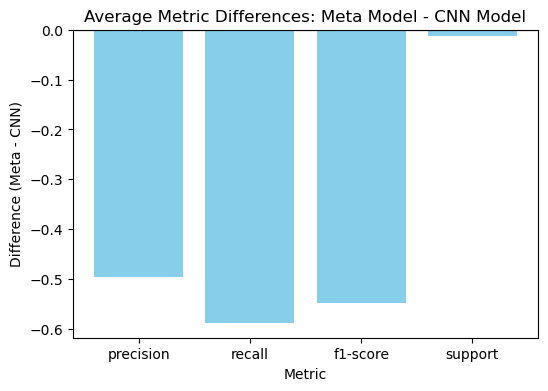

In [96]:
import matplotlib.pyplot as plt

# Take the mean of each metric across all classes
metric_means = diff_report_rq4.mean() * 100 # precision, recall, f1-score

# Simple bar graph
plt.figure(figsize=(6,4))
plt.bar(metric_means.index, metric_means.values, color='skyblue')
plt.title("Average Metric Differences: Meta Model - CNN Model")
plt.ylabel("Difference (Meta - CNN)")
plt.xlabel("Metric")
plt.axhline(0, color='black', linewidth=0.8)
plt.savefig("outputs\Figures\RQ3_Fig2.pdf", dpi=300)
plt.show()

# **RQ 5**:  
**How do noise perturbations like Gaussian noise, affect the performance, prediction accuracy, and misclassification patterns of traffic sign recognition models, specifically comparing a custom CNN and a meta-learner?**

In [97]:
# CNN predictions
probs_test_cnn_rq5 = []
test_labels_rq5 = []
gen_batch_size = 224

test_images_generator = prepare_image_generator_rq(test_data_df, gen_batch_size, model='custom_cnn', rq = 'noise')
for image_batch, labels in test_images_generator:
    probs_test_cnn_rq5.append(custom_cnn.predict(image_batch))
    test_labels_rq5.append(labels)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━

In [98]:
# ResNet50 predictions
probs_test_resnet50_rq5 = []
gen_batch_size = 224

train_images_generator = prepare_image_generator_rq(test_data_df, gen_batch_size, model='resnet50', rq = 'blur')
for image_batch, labels in train_images_generator:
    probs_test_resnet50_rq5.append(resnet50.predict(image_batch))


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 298ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 297ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 305ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 318ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 300ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 374ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 302ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 304ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 309ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 296ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 293ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 295ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 297ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 284ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 302ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 297ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 327ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 304ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 298ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 307ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 307ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 296ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 328ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 328ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 306ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 

In [99]:
probs_test_resnet50_rq5 = np.vstack(probs_test_resnet50_rq5)
probs_test_cnn_rq5 = np.vstack(probs_test_cnn_rq5)
test_labels_rq5 = np.vstack(test_labels_rq5)


probs_test_stack_rq5  = np.hstack([probs_test_cnn_rq5,probs_test_resnet50_rq5])
label_test_stack_rq5 = test_labels_rq5
label_test_stack_rq5 = np.argmax(test_labels_rq5, axis=1)

In [100]:
y_true_meta_rq5 = []
y_pred_meta_rq5 = []

preds_rq5 = meta_learner_model.predict(probs_test_stack_rq5)
y_pred_meta_rq5 = np.argmax(preds_rq5, axis=1)
y_true_meta_rq5 = label_test_stack_rq5

319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [101]:
report_df_rq5 = pd.DataFrame(classification_report(y_true_meta_rq5, y_pred_meta_rq5, output_dict=True, digits=4))
report_df_rq5.transpose()
report_df_rq5.transpose().to_excel("outputs\Tables\RQ5_Tab1.xlsx", index=True)

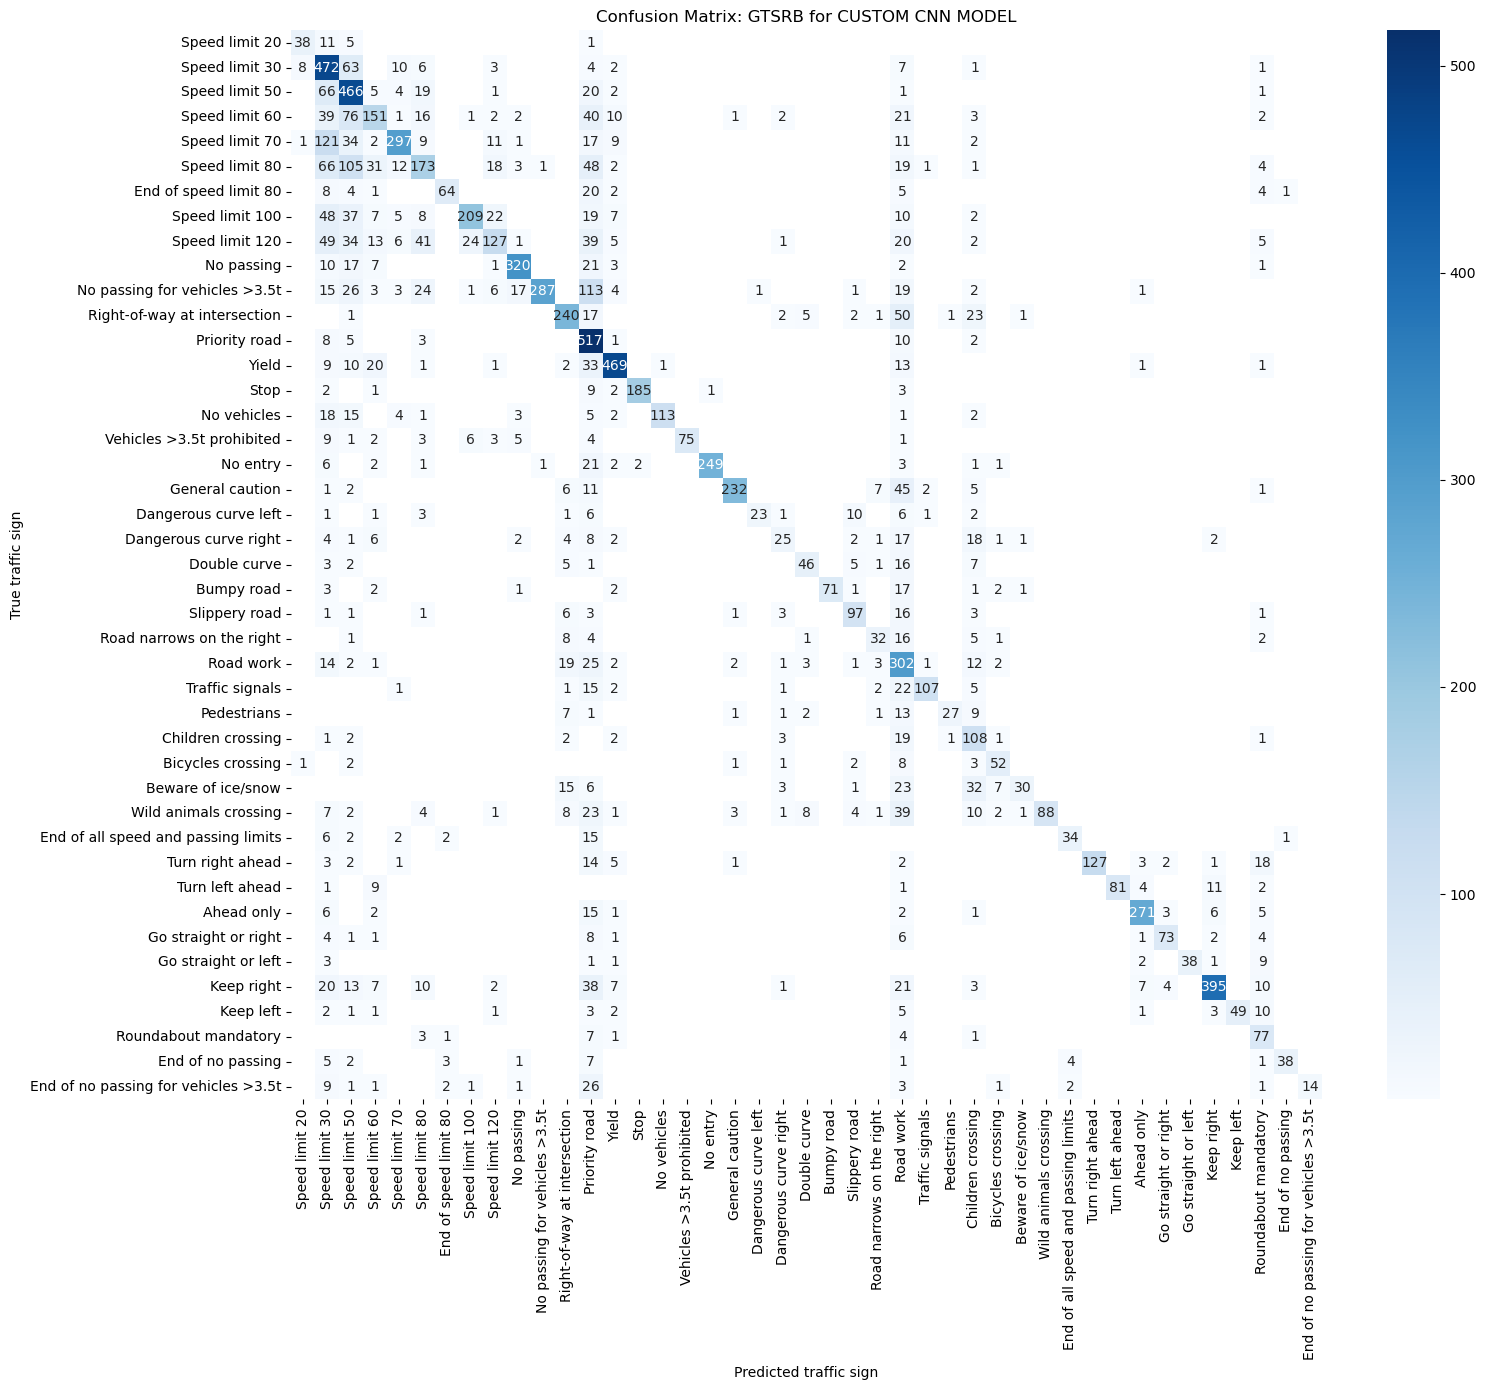

In [102]:
#!pip install matplotlib
import matplotlib.pyplot as plt
import seaborn as sns


cm_rq5 = confusion_matrix(y_true_meta_rq5, y_pred_meta_rq5)
mask_zero = cm_rq5 == 0

plt.figure(figsize=(16,14))
sns.heatmap(
    cm_rq5,    
    annot=cm_rq5,
    fmt = 'd',
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
    mask=mask_zero
)

plt.xlabel("Predicted traffic sign")
plt.ylabel("True traffic sign")
plt.title("Confusion Matrix: GTSRB for CUSTOM CNN MODEL")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("outputs\Figures\RQ5_Fig1.pdf", dpi=300) 
plt.show()


In [103]:
metrics = ["precision", "recall", "f1-score","support"] 
diff_report_rq5 = report_df_rq5.transpose()[metrics] - report_df_comparisons.transpose()[metrics]
diff_report_rq5.to_excel("outputs\Tables\RQ5_Tab2.xlsx", index=True)
diff_report_rq5


,precision,recall,f1-score,support
0,-0.208333,-0.309091,-0.262136,0.000000
1,-0.547450,-0.181976,-0.418417,0.000000
2,-0.500427,-0.201709,-0.385536,0.000000
3,-0.450174,-0.585831,-0.527602,0.000000
4,-0.139677,-0.421359,-0.308163,0.000000
5,-0.465193,-0.638430,-0.568707,0.000000
6,-0.102020,-0.412844,-0.288251,0.000000
7,-0.133690,-0.438503,-0.318755,0.000000
8,-0.361809,-0.651226,-0.549872,0.000000
9,-0.103641,-0.162304,-0.133965,0.000000


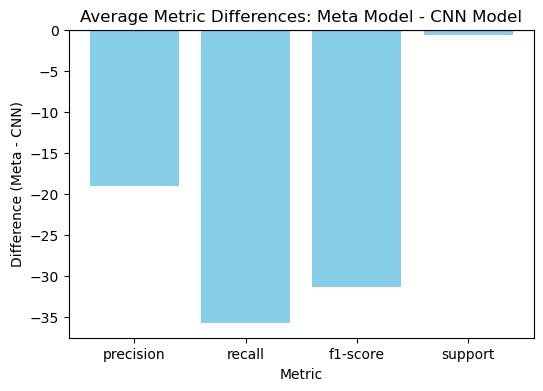

In [104]:
import matplotlib.pyplot as plt

# Take the mean of each metric across all classes
metric_means = diff_report_rq5.mean() * 100 # precision, recall, f1-score

# Simple bar graph
plt.figure(figsize=(6,4))
plt.bar(metric_means.index, metric_means.values, color='skyblue')
plt.title("Average Metric Differences: Meta Model - CNN Model")
plt.ylabel("Difference (Meta - CNN)")
plt.xlabel("Metric")
plt.axhline(0, color='black', linewidth=0.8)
plt.savefig("outputs\Figures\RQ5_Fig2.pdf", dpi=300)
plt.show()